<a href="https://colab.research.google.com/github/dbrnjd/Simulating-Evolutionary-Learning-in-Crypto-Markets/blob/main/layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Install TA-Lib ---
# Download and unzip the TA-Lib source code
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz

# Navigate into the directory
%cd ta-lib/

# Build and install the C-library
!./configure --prefix=/usr
!make
!make install

# Navigate back to the root content directory
%cd ..

# Install the Python wrapper for TA-Lib
!pip install Ta-Lib

--2025-09-05 13:55:46--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-09-05 13:55:47--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://zenlayer.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-09-05 13:55:47--  http://zenlayer.dl.sour

--- Loading and Preparing Data ---
--- Data Loaded and Prepared Successfully ---

--- STARTING ROLLING WINDOW EXPERIMENT ---

--- Running Period: Testing on 2018-10-07 to 2019-04-06 ---
  Building new handbook...
  Optimizing for CDLADVANCEBLOCK (15 opportunities)...
  Optimizing for CDLBELTHOLD (219 opportunities)...
  Optimizing for CDLCLOSINGMARUBOZU (127 opportunities)...
  Optimizing for CDLDOJI (158 opportunities)...
  Optimizing for CDLDRAGONFLYDOJI (29 opportunities)...
  Optimizing for CDLENGULFING (263 opportunities)...
  Optimizing for CDLGRAVESTONEDOJI (19 opportunities)...
  Optimizing for CDLHAMMER (36 opportunities)...
  Optimizing for CDLHANGINGMAN (33 opportunities)...
  Optimizing for CDLHARAMI (148 opportunities)...
  Optimizing for CDLHARAMICROSS (33 opportunities)...
  Optimizing for CDLHIGHWAVE (95 opportunities)...
  Optimizing for CDLHIKKAKE (216 opportunities)...
  Optimizing for CDLLONGLEGGEDDOJI (142 opportunities)...
  Optimizing for CDLLONGLINE (180 opportu

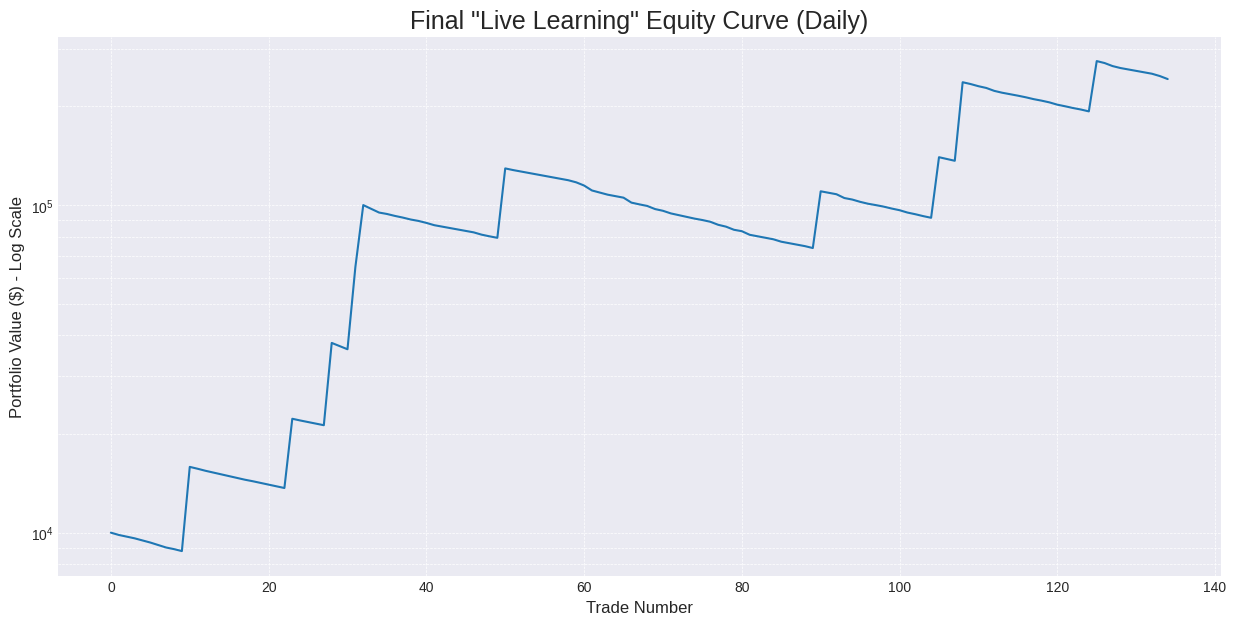

In [ ]:
import pandas as pd
import numpy as np
import talib
import random
import matplotlib.pyplot as plt
from scipy import stats
import json
import os
from datetime import datetime

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
# --- Ensure Google Drive is mounted if using Colab ---
# from google.colab import drive
# drive.mount('/content/drive')

# --- File Paths ---
DRIVE_PATH = "/content/drive/MyDrive/crypto_data/"
FILE_PATH = os.path.join(DRIVE_PATH, "Gemini_BTCUSD_d.csv")
TIME_FRAME = 'daily'

# --- Set Random Seeds for Reproducibility ---
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
pd.options.display.float_format = '{:.4f}'.format

# ==============================================================================
# --- 2. DATA LOADING AND PREPARATION ---
# ==============================================================================
print("--- Loading and Preparing Data ---")
try:
    df = pd.read_csv(FILE_PATH, index_col='Date', parse_dates=True)
    df.sort_index(inplace=True)
    # Clean up columns for consistency
    if 'unix' in df.columns:
        df.drop(columns=['unix', 'Symbol', 'Volume USD'], inplace=True, errors='ignore')
    if 'Volume BTC' in df.columns:
        df.rename(columns={'Volume BTC': 'Volume'}, inplace=True)
    df = df[df['Close'] > 0]

    # Feature Engineering: Generate all TA-Lib candlestick patterns
    candle_patterns = talib.get_function_groups()['Pattern Recognition']
    for pattern in candle_patterns:
        df[pattern] = getattr(talib, pattern)(df['Open'], df['High'], df['Low'], df['Close'])
    df.dropna(inplace=True)
    print("--- Data Loaded and Prepared Successfully ---")
except FileNotFoundError:
    print(f"Error: The file was not found at the path: {FILE_PATH}")
    df = None

# ==============================================================================
# --- 3. GENETIC ALGORITHM CORE FUNCTIONS ---
# ==============================================================================

def create_individual_params_only():
    """Creates a single random 'genome' for a trading rule."""
    if TIME_FRAME == 'daily':
        sl_range, tp_range = (0.01, 0.50), (0.01, 1.00)
    else: # Hourly
        sl_range, tp_range = (0.001, 0.05), (0.001, 0.10)
    genome = {
        "trade_action": 'buy', # Focus only on buy signals for this study
        "stop_loss": round(random.uniform(sl_range[0], sl_range[1]), 4),
        "target": round(random.uniform(tp_range[0], tp_range[1]), 4),
        "position_size": round(random.uniform(0.01, 1.00), 3)
    }
    return genome

def calculate_efficiency_fitness(individual_params, trade_history):
    """Calculates the fitness of a rule based on profit, risk, and time efficiency."""
    if len(trade_history) < 5: return 0

    initial_capital = 10000
    capital = initial_capital
    equity_curve = [initial_capital]

    # Simulate the performance of the rule on the historical trade opportunities
    for trade in trade_history:
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        pnl_percent = (exit_price - entry_price) / entry_price if entry_price != 0 else 0

        final_pnl = pnl_percent
        # Apply the evolved stop-loss and target to the raw outcome
        if pnl_percent <= -individual_params['stop_loss']:
            final_pnl = -individual_params['stop_loss']
        elif pnl_percent >= individual_params['target']:
            final_pnl = individual_params['target']

        capital *= (1 + (final_pnl * individual_params['position_size']))
        equity_curve.append(capital)

    # Calculate metrics for the fitness formula
    equity_arr = np.array(equity_curve)
    total_return = (equity_arr[-1] / initial_capital) - 1

    if total_return <= 0: return 0

    peak = np.maximum.accumulate(equity_arr)
    drawdown = (peak - equity_arr) / peak
    max_drawdown = np.max(drawdown)

    # Use a fixed duration for fitness calculation as per methodology
    avg_duration = trade_history[0]['duration']

    # Final fitness score: Return per unit of risk and time
    fitness_score = total_return / (avg_duration * max_drawdown) if max_drawdown > 1e-6 else 0
    return max(0, fitness_score)

def run_focused_ga(trade_history):
    """Runs the GA to evolve the best parameters for a specific pattern."""
    population_size, num_generations, elitism_count = 50, 25, 2
    population = [create_individual_params_only() for _ in range(population_size)]

    for gen in range(num_generations):
        fitnesses = [calculate_efficiency_fitness(ind, trade_history) for ind in population]

        next_generation = []
        # Elitism: carry over the best individuals
        elite_indices = np.argsort(fitnesses)[-elitism_count:]
        for i in elite_indices:
            next_generation.append(population[i])

        # Selection, Crossover, and Mutation
        weights = np.array(fitnesses) + 1e-6 # Add small value to allow selection
        while len(next_generation) < population_size:
            parent1, parent2 = random.choices(population, weights=weights, k=2)
            child = {k: parent1[k] if random.random() < 0.5 else parent2[k] for k in parent1}
            if random.random() < 0.2: # Mutation
                new_gene_source = create_individual_params_only()
                gene_to_mutate = random.choice(list(child.keys()))
                child[gene_to_mutate] = new_gene_source[gene_to_mutate]
            next_generation.append(child)
        population = next_generation

    final_fitnesses = [calculate_efficiency_fitness(ind, trade_history) for ind in population]
    best_idx = np.argmax(final_fitnesses)
    best_individual = population[best_idx]
    best_individual['fitness_score'] = final_fitnesses[best_idx]
    return best_individual

def build_handbook(training_data):
    """Builds a handbook of rules by running a GA for each candlestick pattern."""
    trade_history_by_pattern = {p: [] for p in candle_patterns}
    hold_time = 10 # Define a fixed look-ahead period for evaluating potential trades in training

    for pattern in candle_patterns:
        signal_indices = training_data.index[training_data[pattern] != 0]
        for idx in signal_indices:
            entry_idx_loc = training_data.index.get_loc(idx)
            if entry_idx_loc + hold_time < len(training_data):
                trade_history_by_pattern[pattern].append({
                    'entry_price': training_data['Close'].iloc[entry_idx_loc],
                    'exit_price': training_data['Close'].iloc[entry_idx_loc + hold_time],
                    'duration': hold_time
                })

    handbook = {}
    for pattern, history in trade_history_by_pattern.items():
        if len(history) >= 10:
            print(f"  Optimizing for {pattern} ({len(history)} opportunities)...")
            best_params = run_focused_ga(history)
            if best_params.get('fitness_score', 0) > 0:
                handbook[pattern] = best_params
    return handbook

def test_handbook(handbook, data, initial_capital=10000):
    """Backtests a given handbook on unseen data, one position at a time."""
    capital = initial_capital
    position_open = False
    trade_log = []

    # Sort handbook by key to ensure deterministic testing if multiple signals appear on same day
    patterns_in_handbook = sorted(handbook.keys())

    for i in range(1, len(data)):
        if position_open:
            current_price = data['Close'].iloc[i]
            pnl_percent = (current_price - entry_price) / entry_price if entry_price != 0 else 0

            # CORRECTED LOGIC: Exit only on SL or TP. No artificial time limit.
            if (pnl_percent <= -open_trade_rule['stop_loss'] or
                pnl_percent >= open_trade_rule['target']):

                final_pnl = -open_trade_rule['stop_loss'] if pnl_percent <= -open_trade_rule['stop_loss'] else open_trade_rule['target']

                position_open = False

                # Log all relevant details of the closed trade
                trade_log.append({
                    'entry_date': entry_date,
                    'exit_date': data.index[i],
                    'entry_price': entry_price,
                    'exit_price': entry_price * (1 + final_pnl),
                    'pnl_percent': final_pnl,
                    'pattern': open_trade_pattern,
                    **open_trade_rule
                })
        else:
            for pattern in patterns_in_handbook:
                if data[pattern].iloc[i] != 0:
                    rule = handbook[pattern]
                    if rule['trade_action'] == 'buy':
                        open_trade_rule = rule
                        open_trade_pattern = pattern
                        position_open = True
                        entry_price = data['Close'].iloc[i]
                        entry_date = data.index[i]
                        break

    return trade_log

def generate_academic_report(trade_log, initial_capital=10000):
    """Generates the final performance report from the complete trade log."""
    if not trade_log:
        return {"Number of Trades": 0, "Sharpe Ratio": 0, "P-value": 1.0, "Total Return (%)": 0, "Max Drawdown (%)": 0}

    # Reconstruct equity curve for accurate drawdown calculation
    capital = initial_capital
    equity_curve = [initial_capital]

    # Sort trades by entry date to correctly reconstruct capital history
    trades_df_sorted = pd.DataFrame(trade_log).sort_values(by='entry_date').reset_index(drop=True)

    running_capital = initial_capital
    for _, trade in trades_df_sorted.iterrows():
        # Capital at risk must be based on the capital at the start of THIS trade
        capital_at_risk = running_capital * trade['position_size']
        pnl_amount = capital_at_risk * trade['pnl_percent']
        running_capital += pnl_amount
        equity_curve.append(running_capital)

    returns = [t['pnl_percent'] for t in trade_log]
    returns_arr = np.array(returns)
    equity_arr = np.array(equity_curve)

    annualization_factor = np.sqrt(365)
    std_dev = np.std(returns_arr)
    sharpe_ratio = (np.mean(returns_arr) / std_dev) * annualization_factor if std_dev > 1e-6 else 0

    t_stat, p_value = stats.ttest_1samp(returns_arr, 0)
    total_return = (equity_arr[-1] / initial_capital) - 1

    peak = np.maximum.accumulate(equity_arr)
    drawdown = (peak - equity_arr) / peak if peak.any() > 0 else np.zeros_like(peak)
    max_drawdown = np.max(drawdown)

    report = {
        "Number of Trades": len(trade_log),
        "Sharpe Ratio": sharpe_ratio,
        "P-value": p_value,
        "Total Return (%)": total_return * 100,
        "Max Drawdown (%)": max_drawdown * 100
    }
    return report

# ==============================================================================
# --- 4. ROLLING WINDOW SCRIPT ---
# ==============================================================================
if df is not None:
    print(f"\n--- STARTING ROLLING WINDOW EXPERIMENT ---")

    periods_in_year = 365
    training_window_size = periods_in_year * 3
    re_train_interval = periods_in_year // 2

    all_trades_log = []
    all_handbooks_log = []

    start_index = 0
    while start_index + training_window_size + re_train_interval <= len(df):
        train_start, train_end = start_index, start_index + training_window_size
        test_start, test_end = train_end, train_end + re_train_interval

        training_slice = df.iloc[train_start:train_end]
        testing_slice = df.iloc[test_start:test_end]

        print(f"\n--- Running Period: Testing on {testing_slice.index[0].date()} to {testing_slice.index[-1].date()} ---")

        print(f"  Building new handbook...")
        current_handbook = build_handbook(training_slice)
        all_handbooks_log.append({
            "training_end_date": training_slice.index[-1].strftime('%Y-%m-%d'),
            "handbook": current_handbook
        })
        print(f"  Handbook built with {len(current_handbook)} rules.")

        print("  Testing handbook on unseen data...")
        # To get the starting capital for this period, we reconstruct the equity curve from past trades
        current_capital = 10000
        # Sort trades by entry date to correctly compound capital
        sorted_trades = sorted(all_trades_log, key=lambda x: x['entry_date'])
        for trade in sorted_trades:
            # This is a simplified compounding for the next period's starting capital
            current_capital += current_capital * trade['position_size'] * trade['pnl_percent']

        period_trade_log = test_handbook(current_handbook, testing_slice, initial_capital=current_capital)
        all_trades_log.extend(period_trade_log)

        start_index += re_train_interval

# ==============================================================================
# --- 5. FINAL RESULTS & SAVE ---
# ==============================================================================
    # --- SAVE DETAILED RESULTS FIRST for robust analysis ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    RESULTS_PATH = os.path.join(DRIVE_PATH, f"dissertation_results_{timestamp}")
    os.makedirs(RESULTS_PATH, exist_ok=True)
    print(f"\n--- Saving detailed results to: {RESULTS_PATH} ---")

    # Save detailed trades log, which is the ground truth
    trades_df = pd.DataFrame(all_trades_log)
    trades_df.to_csv(os.path.join(RESULTS_PATH, 'detailed_trades.csv'), index=False)
    print("  Saved detailed_trades.csv")

    # Save all handbooks
    with open(os.path.join(RESULTS_PATH, 'all_handbooks.json'), 'w') as f:
        json.dump(all_handbooks_log, f, indent=4)
    print("  Saved all_handbooks.json")

    # --- GENERATE AND SAVE FINAL REPORT ---
    print("\n--- Generating Final Report ---")
    final_report = generate_academic_report(all_trades_log)
    for key, value in final_report.items():
        print(f"  {key}: {value:.4f}")

    with open(os.path.join(RESULTS_PATH, 'final_report.json'), 'w') as f:
        json.dump(final_report, f, indent=4)
    print("\n  Saved final_report.json")

    # --- PLOT FINAL EQUITY CURVE ---
    # Reconstruct final equity curve from the complete trade log for the plot
    initial_capital = 10000
    equity_curve = [initial_capital]

    # Sort trades by entry date to correctly compound capital for the plot
    sorted_trades_df = pd.DataFrame(all_trades_log).sort_values(by='entry_date').reset_index(drop=True)
    capital = initial_capital
    for _, trade in sorted_trades_df.iterrows():
        # Capital at risk for each trade is based on the capital at the START of that trade
        capital_at_risk = capital * trade['position_size']
        pnl_amount = capital_at_risk * trade['pnl_percent']
        capital += pnl_amount
        equity_curve.append(capital)

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(15, 7))
    plt.plot(equity_curve)
    plt.yscale('log')
    plt.title(f'Final "Live Learning" Equity Curve ({TIME_FRAME.capitalize()})', fontsize=18)
    plt.xlabel('Trade Number', fontsize=12)
    plt.ylabel('Portfolio Value ($) - Log Scale', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(RESULTS_PATH, 'final_equity_curve.png'))
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
# --- File Paths ---
BASE_PATH = "/content/drive/MyDrive/crypto_data/"
BTC_FILE_PATH = os.path.join(BASE_PATH, "Gemini_BTCUSD_d.csv")

# --- Automatically find the latest results folder ---
try:
    all_result_dirs = [d for d in os.listdir(BASE_PATH) if d.startswith('dissertation_results_') and os.path.isdir(os.path.join(BASE_PATH, d))]
    all_result_dirs.sort()
    LATEST_RESULTS_FOLDER = all_result_dirs[-1]
    RESULTS_PATH = os.path.join(BASE_PATH, LATEST_RESULTS_FOLDER)
    print(f"--- Automatically selected the latest results folder: {LATEST_RESULTS_FOLDER} ---")
except (FileNotFoundError, IndexError):
    print(f"ERROR: Could not find any 'dissertation_results_' folders in {BASE_PATH}")
    RESULTS_PATH = None
    sys.exit()

# Create a sub-directory for analysis plots
ANALYSIS_PLOTS_PATH = os.path.join(RESULTS_PATH, 'analysis_plots')
os.makedirs(ANALYSIS_PLOTS_PATH, exist_ok=True)

# ==============================================================================
# --- 2. DATA LOADING & PREPARATION ---
# ==============================================================================

def load_and_prepare_data(results_path, initial_capital=10000):
    """Loads all necessary files and robustly reconstructs a daily equity curve from the trade log."""
    print("\n--- Loading data from simulation run ---")
    try:
        trades_df = pd.read_csv(os.path.join(results_path, 'detailed_trades.csv'), parse_dates=['entry_date', 'exit_date'])
        with open(os.path.join(results_path, 'all_handbooks.json'), 'r') as f:
            all_handbooks = json.load(f)
        with open(os.path.join(results_path, 'final_report.json'), 'r') as f:
            final_report = json.load(f)

        btc_price_df = pd.read_csv(BTC_FILE_PATH, index_col='Date', parse_dates=True)

        # --- FIX APPLIED HERE ---
        # Ensure the benchmark data's index is sorted to prevent slicing errors
        btc_price_df.sort_index(inplace=True)

        # --- ROBUST EQUITY CURVE RECONSTRUCTION ---
        if not trades_df.empty:
            trades_df.sort_values(by='exit_date', inplace=True)

            capital_at_date = {}
            # Start with initial capital one day before the very first trade to establish a baseline
            if not trades_df.empty:
                    capital_at_date[trades_df['entry_date'].min() - pd.Timedelta(days=1)] = initial_capital

            # Reconstruct the capital history trade by trade
            for _, trade in trades_df.iterrows():
                # Find capital at start of the trade by looking at the last known equity value
                trade_start_cap = pd.Series(capital_at_date).asof(trade['entry_date'])

                capital_at_risk = trade_start_cap * trade['position_size']
                pnl_amount = capital_at_risk * trade['pnl_percent']
                end_capital = trade_start_cap + pnl_amount
                capital_at_date[trade['exit_date']] = end_capital

            dated_equity = pd.Series(capital_at_date).sort_index()

            # Create a full daily index and forward-fill the equity values
            full_date_range = pd.date_range(start=dated_equity.index.min(), end=btc_price_df.index.max(), freq='D')
            daily_equity_curve_df = dated_equity.reindex(full_date_range).ffill().to_frame(name='equity').dropna()
        else:
            daily_equity_curve_df = pd.DataFrame(columns=['equity'])

        print("--- Data loaded and daily equity curve reconstructed successfully ---")
        return trades_df, daily_equity_curve_df, all_handbooks, final_report, btc_price_df

    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        return None, None, None, None, None

# ==============================================================================
# --- 3. ANALYSIS FUNCTIONS ---
# ==============================================================================

def answer_rq1(all_handbooks, results_path):
    """Analyzes the nature of the emergent strategies from the handbooks."""
    print("\n--- Answering RQ1: What is the nature of the emergent strategies? ---")
    if not all_handbooks: print("No handbook data to analyze."); return

    param_data = []
    for e in all_handbooks:
        if e['handbook']:
            df = pd.DataFrame.from_dict(e['handbook'], orient='index')
            avg_params = df.mean(numeric_only=True).to_dict()
            avg_params['date'] = pd.to_datetime(e['training_end_date'])
            param_data.append(avg_params)

    if param_data:
        evo_df = pd.DataFrame(param_data).set_index('date')
        if 'stop_loss' in evo_df.columns and 'target' in evo_df.columns:
                evo_df['rr'] = evo_df['target'] / evo_df['stop_loss'].replace(0, np.nan)

        fig, axes = plt.subplots(4, 1, figsize=(20, 25), sharex=True)
        fig.suptitle('Evolution of Average Rule Parameters Over Time', fontsize=24, y=0.92)

        if 'stop_loss' in evo_df.columns: axes[0].plot(evo_df.index, evo_df['stop_loss'], 'o-', c='firebrick'); axes[0].set(title='Average Stop Loss (%)', ylabel='Stop Loss')
        if 'target' in evo_df.columns: axes[1].plot(evo_df.index, evo_df['target'], 'o-', c='forestgreen'); axes[1].set(title='Average Target (%)', ylabel='Target')
        if 'position_size' in evo_df.columns: axes[2].plot(evo_df.index, evo_df['position_size'], 'o-', c='darkorange'); axes[2].set(title='Average Position Size', ylabel='Fraction of Capital')
        if 'rr' in evo_df.columns: axes[3].plot(evo_df.index, evo_df['rr'], 'o-', c='mediumpurple'); axes[3].set(title='Average Risk/Reward Ratio (Target/SL)', ylabel='Ratio')

        plt.xticks(rotation=45); plt.tight_layout(rect=[0, 0, 1, 0.9])

        # --- ADDED PRINT STATEMENT ---
        print("\n--- Parameter Evolution Data ---")
        if 'evo_df' in locals():
            print(evo_df.to_string())

        save_path = os.path.join(ANALYSIS_PLOTS_PATH, 'parameter_evolution.png'); plt.savefig(save_path); plt.close(fig)
        print(f"\nParameter evolution plot saved to: {save_path}\n")

    all_rules = [{'pattern': p, 'fitness': params.get('fitness_score', 0)} for e in all_handbooks for p, params in e['handbook'].items()]
    if all_rules:
        rules_df = pd.DataFrame(all_rules)
        freq = rules_df['pattern'].value_counts()
        avg_fit = rules_df.groupby('pattern')['fitness'].mean().sort_values(ascending=False)
        fig, axes = plt.subplots(1, 2, figsize=(24, 8)); fig.suptitle('Analysis of Evolved Candlestick Pattern Rules', fontsize=20)
        sns.barplot(ax=axes[0], x=freq.head(15).index, y=freq.head(15).values, palette='viridis', hue=freq.head(15).index, legend=False); axes[0].set_title('Top 15 Most Frequently Evolved Patterns'); axes[0].tick_params(axis='x', rotation=90)
        sns.barplot(ax=axes[1], x=avg_fit.head(15).index, y=avg_fit.head(15).values, palette='plasma', hue=avg_fit.head(15).index, legend=False); axes[1].set_title('Top 15 Patterns by Average Fitness Score'); axes[1].tick_params(axis='x', rotation=90)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # --- ADDED PRINT STATEMENTS ---
        print("\n--- Pattern Frequency Data (Top 15) ---")
        if 'freq' in locals():
            print(freq.head(15).to_string())

        print("\n--- Pattern Average Fitness Data (Top 15) ---")
        if 'avg_fit' in locals():
            print(avg_fit.head(15).to_string())

        save_path = os.path.join(ANALYSIS_PLOTS_PATH, 'pattern_analysis.png'); plt.savefig(save_path); plt.close(fig)
        print(f"\nPattern analysis plot saved to: {save_path}")

def analyze_robustness_and_benchmark(trades_df, equity_curve_df, btc_price_df, final_report, results_path, initial_capital=10000):
    """Analyzes strategy robustness and compares it to a buy-and-hold benchmark."""
    print("\n--- Answering RQ2: How robust are the evolved strategies? ---")
    if trades_df.empty: print("No trades to analyze."); return

    wins = trades_df[trades_df['pnl_percent'] > 0]; losses = trades_df[trades_df['pnl_percent'] <= 0]
    stats = {'Total Trades': len(trades_df), 'Win Rate (%)': len(wins) / len(trades_df) * 100 if len(trades_df) > 0 else 0, 'Avg Profit (%)': wins['pnl_percent'].mean() * 100 if not wins.empty else 0, 'Avg Loss (%)': losses['pnl_percent'].mean() * 100 if not losses.empty else 0, 'Profit Factor': abs(wins['pnl_percent'].sum() / losses['pnl_percent'].sum()) if not losses.empty and losses['pnl_percent'].sum() != 0 else np.inf}
    stats_df = pd.DataFrame([stats]); print("\nDetailed Trade Statistics:"); print(stats_df.to_string(index=False))
    stats_df.to_csv(os.path.join(results_path, 'trade_statistics.csv'), index=False)
    print(f"\nTrade statistics table saved to: {os.path.join(results_path, 'trade_statistics.csv')}")

    plt.style.use('seaborn-v0_8-whitegrid'); fig, ax = plt.subplots(figsize=(12, 7))
    sns.histplot(trades_df['pnl_percent'] * 100, bins=30, kde=True, ax=ax, color='teal', alpha=0.5)
    ax.set_title('Distribution of Out-of-Sample Trade Returns (PnL %)', fontsize=18); ax.set_xlabel('Return (%)')
    plt.savefig(os.path.join(ANALYSIS_PLOTS_PATH, 'pnl_distribution.png')); plt.close(fig)
    print(f"PnL distribution plot saved to: {os.path.join(ANALYSIS_PLOTS_PATH, 'pnl_distribution.png')}")

    print("\n--- Calculating Buy-and-Hold Benchmark ---")
    if equity_curve_df.empty: print("ERROR: Strategy equity curve is empty."); return

    valid_dates = equity_curve_df.index.intersection(btc_price_df.index)
    if len(valid_dates) < 2:
        print("ERROR: Not enough overlapping dates to calculate benchmark."); return

    start_date, end_date = valid_dates.min(), valid_dates.max()
    benchmark_prices = btc_price_df.loc[start_date:end_date]['Close']

    benchmark_equity = (benchmark_prices / benchmark_prices.iloc[0]) * initial_capital
    benchmark_returns = benchmark_prices.pct_change().dropna()
    bnh_return = (benchmark_equity.iloc[-1] / benchmark_equity.iloc[0] - 1) * 100
    bnh_sharpe = (benchmark_returns.mean() / benchmark_returns.std()) * np.sqrt(365) if benchmark_returns.std() > 0 else 0
    bnh_max_dd = ((benchmark_equity / benchmark_equity.cummax()) - 1).min() * 100

    benchmark_df = pd.DataFrame({'Metric': ['Total Return (%)', 'Annualized Sharpe Ratio', 'Max Drawdown (%)'], 'Evolved Strategy': [final_report['Total Return (%)'], final_report['Sharpe Ratio'], -final_report['Max Drawdown (%)']], 'Buy and Hold': [bnh_return, bnh_sharpe, bnh_max_dd]}).set_index('Metric')
    print("\nStrategy vs. Buy-and-Hold Benchmark:"); print(benchmark_df)
    benchmark_df.to_csv(os.path.join(results_path, 'benchmark_comparison.csv'))
    print(f"\nBenchmark comparison table saved to: {os.path.join(results_path, 'benchmark_comparison.csv')}")

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(equity_curve_df.loc[start_date:end_date].index, equity_curve_df.loc[start_date:end_date]['equity'], label='Evolved Strategy', lw=2)
    ax.plot(benchmark_equity.index, benchmark_equity, label='Buy and Hold Benchmark', ls='--')
    ax.set(yscale='log', title='Evolved Strategy vs. Buy-and-Hold Benchmark (Log Scale)', xlabel='Date', ylabel='Portfolio Value ($)')
    ax.legend(); plt.savefig(os.path.join(ANALYSIS_PLOTS_PATH, 'equity_curve_comparison.png')); plt.close(fig)
    print(f"Equity curve comparison plot saved to: {os.path.join(ANALYSIS_PLOTS_PATH, 'equity_curve_comparison.png')}")

def analyze_adaptive_learning(all_handbooks, trades_df, btc_price_df, results_path):
    print("\n--- Answering RQ3: What does the behavior reveal about adaptive learning? ---")

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(btc_price_df.index, btc_price_df['Close'], label='BTC Price', color='gray', alpha=0.5)
    if not trades_df.empty:
        ax.scatter(trades_df[trades_df.pnl_percent > 0].entry_date, trades_df[trades_df.pnl_percent > 0].entry_price, c='g', marker='^', s=100, label='Win', edgecolors='k')
        ax.scatter(trades_df[trades_df.pnl_percent <= 0].entry_date, trades_df[trades_df.pnl_percent <= 0].entry_price, c='r', marker='v', s=100, label='Loss', edgecolors='k')
    ax.set(yscale='log', title='BTC/USD Price with Evolved Strategy Trades', xlabel='Date', ylabel='Price ($)')
    ax.legend(); plt.savefig(os.path.join(ANALYSIS_PLOTS_PATH, 'price_chart_with_trades.png')); plt.close(fig)
    print(f"Price chart with trades saved to: {os.path.join(ANALYSIS_PLOTS_PATH, 'price_chart_with_trades.png')}")

    vol_data = []
    for entry in all_handbooks:
        try:
            end_date = pd.to_datetime(entry['training_end_date'])
            start_date = end_date - pd.DateOffset(years=3)
            training_dates = btc_price_df.index.intersection(pd.date_range(start_date, end_date))
            if len(training_dates) > 1:
                training_slice = btc_price_df.loc[training_dates]['Close']
                daily_returns = training_slice.pct_change().dropna()
                if not daily_returns.empty:
                    vol_data.append({'volatility': daily_returns.std() * np.sqrt(365), 'num_rules': len(entry['handbook'])})
        except Exception as e:
            print(f"Warning: Could not process handbook for date {entry['training_end_date']}. Skipping.")

    if not vol_data:
        print("\nERROR: No volatility data calculated.");
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.set_title('Market Volatility vs. Number of Evolved Rules (No Data)', fontsize=16)
        ax.set_xlabel('Annualized Volatility')
        ax.set_ylabel('Number of Rules')
        plt.savefig(os.path.join(ANALYSIS_PLOTS_PATH, 'volatility_vs_rules.png')); plt.close(fig)
        return

    vol_df = pd.DataFrame(vol_data)
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.regplot(data=vol_df, x='volatility', y='num_rules', ax=ax, line_kws={'color':'red'})
    ax.set(title='Market Volatility vs. Number of Evolved Rules', xlabel='Annualized Volatility', ylabel='Number of Rules')

    # --- ADDED PRINT STATEMENT ---
    print("\n--- Volatility vs. Number of Rules Data ---")
    if 'vol_df' in locals():
        print(vol_df.to_string())

    plt.savefig(os.path.join(ANALYSIS_PLOTS_PATH, 'volatility_vs_rules.png')); plt.close(fig)
    print(f"\nVolatility vs rules plot saved to: {os.path.join(ANALYSIS_PLOTS_PATH, 'volatility_vs_rules.png')}")

# ==============================================================================
# --- 5. MAIN EXECUTION SCRIPT ---
# ==============================================================================

if __name__ == "__main__":
    if RESULTS_PATH:
        trades, daily_equity, handbooks, report, btc_price = load_and_prepare_data(RESULTS_PATH)

        if all(v is not None for v in [trades, daily_equity, handbooks, report, btc_price]):
            answer_rq1(handbooks, RESULTS_PATH)
            analyze_robustness_and_benchmark(trades, daily_equity, btc_price, report, RESULTS_PATH)
            analyze_adaptive_learning(handbooks, trades, btc_price, RESULTS_PATH)

            print("\n--- Analysis Complete. All files saved to Google Drive. ---")
        else:
            print("\n--- Analysis script terminated because data could not be loaded. ---")
    else:
        print("\n--- No results folder found. Analysis cannot proceed. ---")

--- Automatically selected the latest results folder: dissertation_results_20250905_143850 ---

--- Loading data from simulation run ---
--- Data loaded and daily equity curve reconstructed successfully ---

--- Answering RQ1: What is the nature of the emergent strategies? ---

--- Parameter Evolution Data ---
            stop_loss  target  position_size  fitness_score      rr
date                                                               
2018-10-06     0.0135  0.7569         0.9753    230150.7503 56.0289
2019-04-06     0.0144  0.7062         0.9835    240951.6570 48.9978
2019-10-05     0.0144  0.7575         0.9782   1679237.3022 52.4687
2020-04-04     0.0139  0.6325         0.9812    539637.1109 45.3589
2020-10-03     0.0152  0.6871         0.9826    102672.5672 45.1926
2021-04-03     0.0152  0.6663         0.9815    529230.6874 43.7287
2021-10-02     0.0167  0.6891         0.9862    276600.5560 41.2870
2022-02-23     0.0156  0.6839         0.9386    124977.0359 43.8501
2022-05-